DSF (CSE 519) - HW2 <br>
Harsh Prakash Gupta - 115621062

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS,TfidfVectorizer
import re
from textblob import TextBlob
from textstat import flesch_kincaid_grade
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import string

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Task1 - Load the summaries_train.csv and prompts_train.csv files, joined to replace the prompt_IDs with the relevant text fields into a dataframe.

This can be accomplished by using inner left join on these 2 dataframes. As we can see that Summaries_train file has 5 columns, prompts_train file has 4 columns, so on merge using a common column, the number of columns in merged dataframe are 5+4-1=8

In [3]:
summaries_train_df = pd.read_csv('data/summaries_train.csv')
print (summaries_train_df.shape)
prompts_train_df = pd.read_csv('data/prompts_train.csv')
print (prompts_train_df.shape)
merged_df = pd.merge(summaries_train_df, prompts_train_df, on='prompt_id', how='left')
print (merged_df.shape)
print(merged_df.head())


(7165, 5)
(4, 4)
(7165, 8)
     student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1 -0.548304  0.506755  Summarize the various ways the factory would u...   
2  3.128928  4.231226  In complete sentences, summarize the structure...   
3 -0.210614 -0.471415  In complete sentences, summarize the structure...   
4  3.272894  3.219757  Summarize how the Third Wave developed over su...   

                prompt_title  \
0  

Task 2 - 
Construct a table of five features (really 7) from the text for each instance: (10 points)
- Number of words in student response (text) and prompt (prompt_text)
- Number of distinct words in student response (text) and prompt (prompt_text)
- Number of words common to student response (text) and prompt (prompt_text)
- Number of words common to student response (text) and prompt_question
- Number of words common to student response (text) and prompt_title


I have defined some custom functions to count number of words in a text, count number of distinct words in a text and count number of common words between 2 pieces of text. Then I use apply function of pandas which helps me applying required functions across existing columns of dataframe.

In [4]:
def count_words(text):
    return len(str(text).split())
def count_distinct_words(text):
    return len(set(str(text).split()))
def count_common_words(text1, text2):
    return len(set(str(text1).split())&set(str(text2).split()))

merged_df['num_words_response'] = merged_df['text'].apply(count_words)
merged_df['num_words_prompt'] = merged_df['prompt_text'].apply(count_words)
merged_df['num_distinct_words_response'] = merged_df['text'].apply(count_distinct_words)
merged_df['num_distinct_words_prompt'] = merged_df['prompt_text'].apply(count_distinct_words)
merged_df['num_common_words_response_prompt'] = merged_df.apply(lambda row: count_common_words(row['text'], row['prompt_text']), axis=1)
merged_df['num_common_words_response_prompt_question'] = merged_df.apply(lambda row: count_common_words(row['text'], row['prompt_question']), axis=1)
merged_df['num_common_words_response_prompt_title'] = merged_df.apply(lambda row: count_common_words(row['text'], row['prompt_title']), axis=1)

print(merged_df.head()) #8+7 features=15 columns now


     student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1 -0.548304  0.506755  Summarize the various ways the factory would u...   
2  3.128928  4.231226  In complete sentences, summarize the structure...   
3 -0.210614 -0.471415  In complete sentences, summarize the structure...   
4  3.272894  3.219757  Summarize how the Third Wave developed over su...   

                prompt_title  \
0             The Third Wave  

In [5]:
print (merged_df.shape)

(7165, 15)


Task 3 - Now fortify this list with at least five other numerical features.  Consider readability indices, counts of words from particular classes (e.g character length, part of speech, popularity).  Use your imagination as to what might be helpful for identifying well written summaries of texts.

As shown in Task 4 , content and wording a good correlation (0.75). Thus it would make sense to keep most of the features common between them when we are training model to predict these two. But we can try keeping some distinct features for both content and wording as some of the features can be strongly related to either content or wording and don't make much sense for the other.

Common new features for predicting content and wording - <br>
- Flesch-Kincaid Readability Score - Measures the readability of the text
- Count of Punctuation Marks - Proper use of punctuation can be indicative of good writing skills, affecting both the content and the wording
- Word-to-Sentence Ratio - This could indicate the complexity and readability of the text, which is important for both content and wording
- Count of Numerical Figures - The use of numerical figures could indicate specificity and data-driven arguments, which might be a positive indicator for both content and wording.
- Sentiment Score - Well-written summaries might maintain the sentiment of the original text, affecting both content and wording
<br>

Distinct New features for content - <br>
- Count of Nouns - Nouns often carry the subject matter of the text, which is crucial for the content
- Cosine Similarity with Prompt - A high cosine similarity between the TF-IDF vectors of the summary and the prompt could indicate that the summary covers the prompt's topic well.
<br>

Distict New features for wording - <br>
- Lexical Diversity - A higher ratio of unique words to the total number of words can indicate a rich vocabulary, which could be a sign of well-chosen wording.
- Count of Adjectives and Adverbs - The use of adjectives and adverbs can enhance the descriptiveness and quality of the wording.
- Count of Pronouns - Excessive use of pronouns might indicate vagueness, while fewer pronouns might indicate more specific and clear wording


In [6]:
def fk_readability(text):
    return flesch_kincaid_grade(text)
def sentiment_polarity(text):
    return TextBlob(str(text)).sentiment.polarity
def count_pos(text, pos):
    tagged = nltk.pos_tag(str(text).split())
    count = sum(1 for word,pos_tag in tagged if pos_tag==pos)
    return count

def lexical_diversity(text):
    words = str(text).split()
    return len(set(words))/len(words) if len(words) >0 else 0
def count_punctuation(text):
    return sum(1 for char in text if char in '.,:;!?')
def word_to_sentence_ratio(text):
    sentences = text.split('.')
    return len(text.split())/len(sentences) if len(sentences)> 0 else 0
def count_numerical(text):
    return sum(1 for word in text.split() if word.isdigit())

In [7]:
# Add common features
merged_df['fk_readability_response'] = merged_df['text'].apply(fk_readability)
merged_df['sentiment_polarity_response'] = merged_df['text'].apply(sentiment_polarity)
merged_df['count_punctuation_response'] = merged_df['text'].apply(count_punctuation)
merged_df['word_to_sentence_ratio_response'] = merged_df['text'].apply(word_to_sentence_ratio)
merged_df['count_numerical_response'] = merged_df['text'].apply(count_numerical)

# Add distinct features for 'content'
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(merged_df['text'])
prompt_tfidf_matrix = vectorizer.transform(merged_df['prompt_text'])
merged_df['cosine_similarity_with_prompt'] = [cosine_similarity(tfidf_matrix[i], prompt_tfidf_matrix[i])[0][0] for i in range(len(merged_df))]
merged_df['count_nouns_response'] = merged_df['text'].apply(lambda x: count_pos(x, 'NN'))

# Add distinct features for 'wording'
merged_df['lexical_diversity_response'] = merged_df['text'].apply(lexical_diversity)
merged_df['count_adjectives_adverbs_response'] = merged_df['text'].apply(lambda x: count_pos(x, 'JJ') + count_pos(x, 'RB'))
merged_df['count_pronouns_response'] = merged_df['text'].apply(lambda x: count_pos(x, 'PRP') + count_pos(x, 'PRP$'))

print(merged_df.head())
print(merged_df.shape)

     student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1 -0.548304  0.506755  Summarize the various ways the factory would u...   
2  3.128928  4.231226  In complete sentences, summarize the structure...   
3 -0.210614 -0.471415  In complete sentences, summarize the structure...   
4  3.272894  3.219757  Summarize how the Third Wave developed over su...   

                prompt_title  \
0             The Third Wave  

Task 4 - Look at the distributions of scores for content and wording, as histograms and scatterplots? What is the range of values here? How well correlated are they?   Do the shapes of these distributions differ for the different prompts?

In first graph I show Distribution of content and wording scores with help of histograms.
In second graph, I build a scatterplot between 'content' and 'wording' scores.
The overall correlation between content and wording is coming 0.75, which indicates that they are having a good amount of correlation.
As we have 4 unique prompts, I have also plotted distribution plots of content,wording scores and scatterplot for each prompt. I have also calculated correlation between 'content' and 'wording' for each prompt and it is coming in range from 0.69 to 0.81.

d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

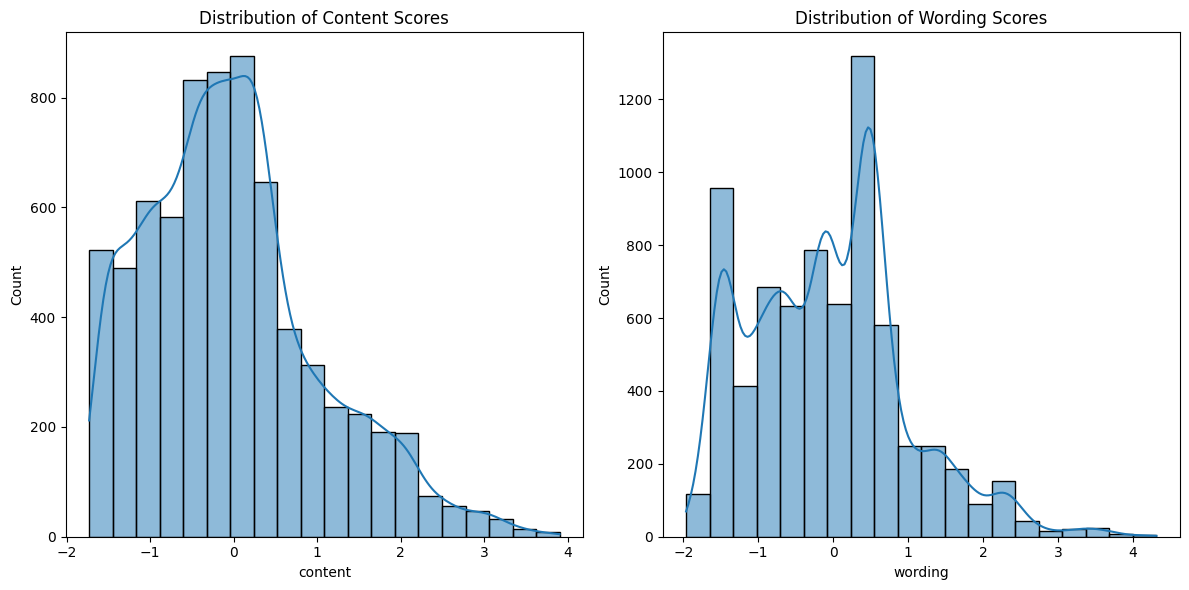

d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


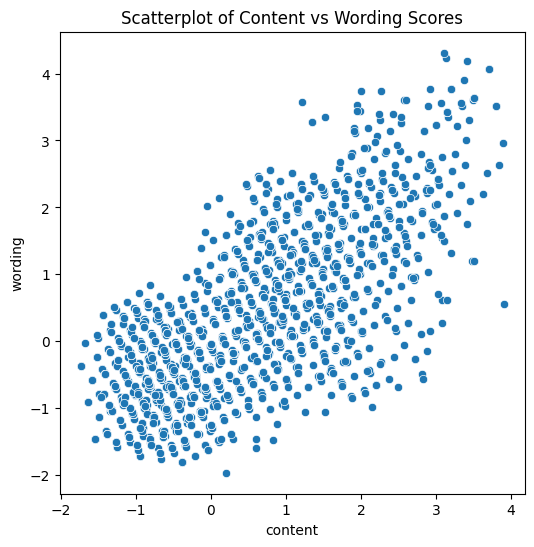

d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

The overall correlation between 'content' and 'wording' is 0.75
Number of unique prompts: 4



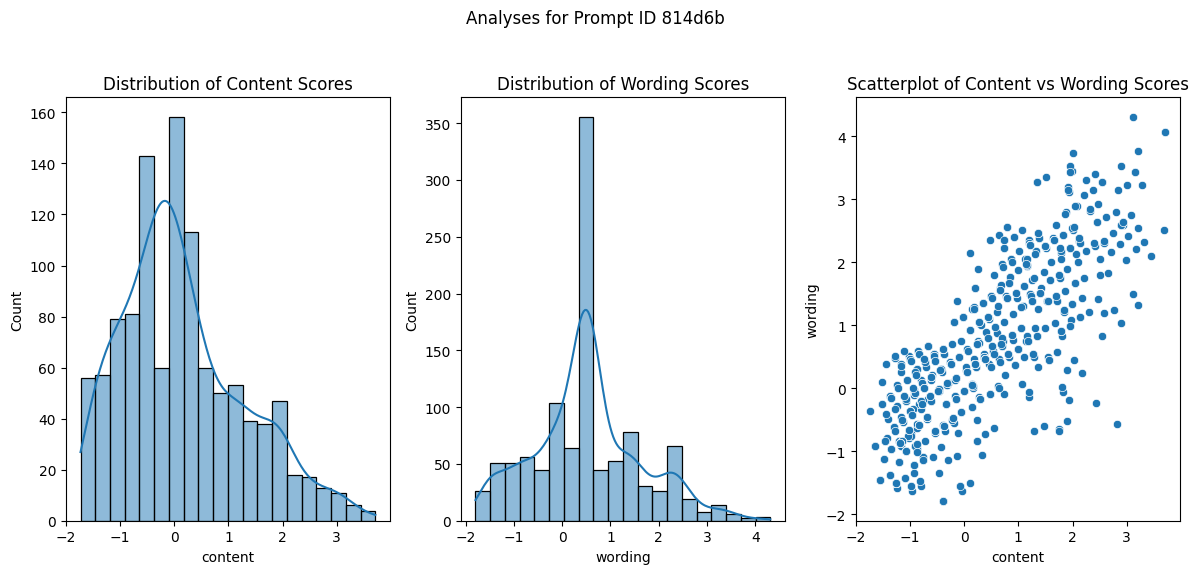

The correlation between 'content' and 'wording' for Prompt ID 814d6b is 0.81


d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

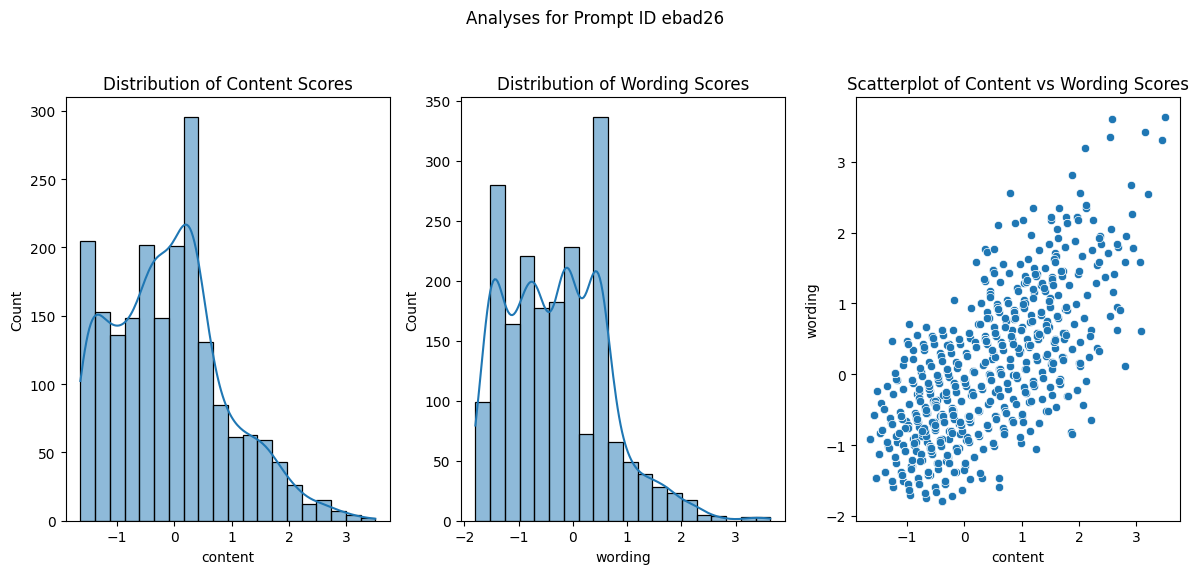

The correlation between 'content' and 'wording' for Prompt ID ebad26 is 0.75


d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

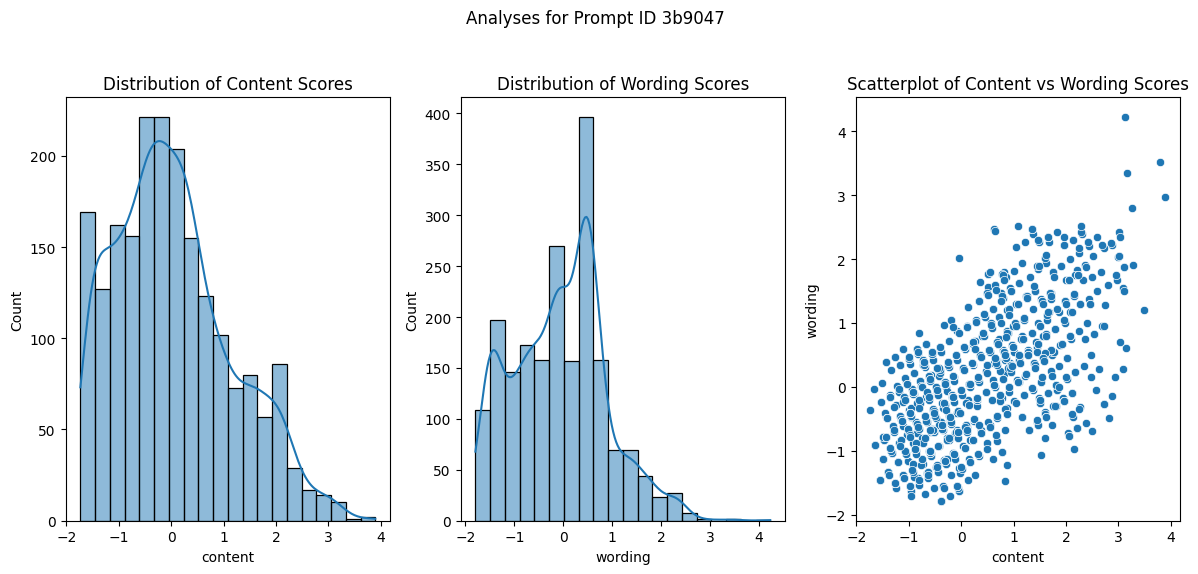

The correlation between 'content' and 'wording' for Prompt ID 3b9047 is 0.69


d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

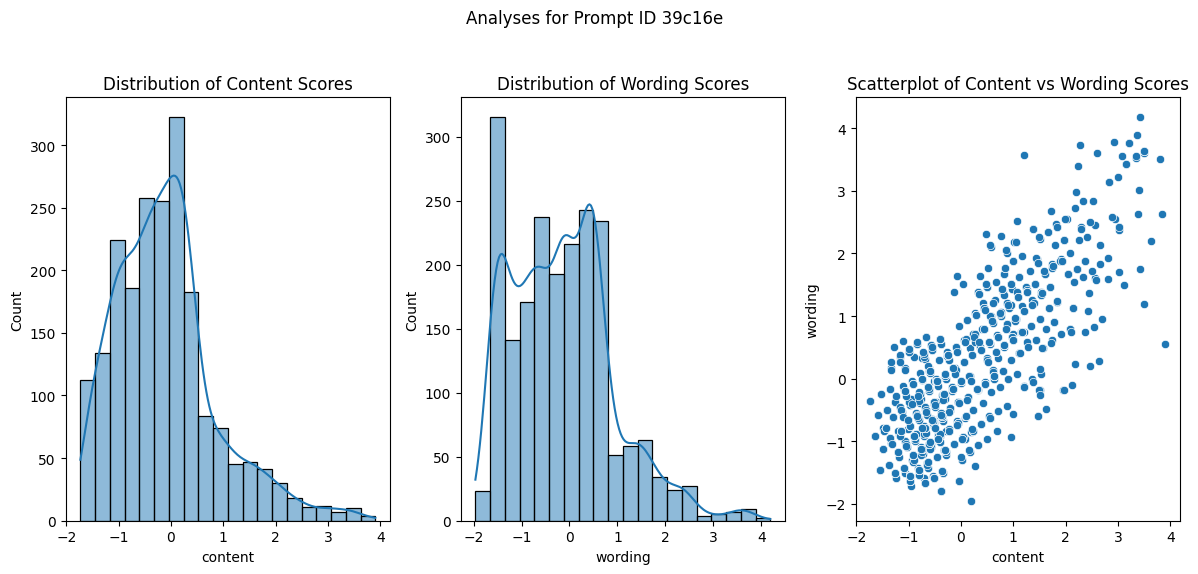

The correlation between 'content' and 'wording' for Prompt ID 39c16e is 0.81


In [8]:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Distribution of Content Scores')
sns.histplot(merged_df['content'], bins=20, kde=True)

plt.subplot(1, 2,2)
plt.title('Distribution of Wording Scores')
sns.histplot(merged_df['wording'], bins=20, kde=True)

plt.tight_layout()
plt.show()

# Scatterplot for 'content' vs 'wording'
plt.figure(figsize=(6, 6))
sns.scatterplot(x='content', y='wording', data=merged_df)
plt.title('Scatterplot of Content vs Wording Scores')
plt.show()

# Correlation between 'content' and 'wording'
correlation = merged_df['content'].corr(merged_df['wording'])
print(f"The overall correlation between 'content' and 'wording' is {correlation:.2f}")

# Distributions and scatterplots per prompt
unique_prompts = merged_df['prompt_id'].unique()
print (f"Number of unique prompts: {len(unique_prompts)}\n")
for prompt in unique_prompts:
    subset_df = merged_df[merged_df['prompt_id'] ==prompt]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Analyses for Prompt ID {prompt}")
    
    plt.subplot(1,3,1)
    plt.title('Distribution of Content Scores')
    sns.histplot(subset_df['content'], bins=20,kde=True)
    
    plt.subplot(1, 3,2)
    plt.title('Distribution of Wording Scores')
    sns.histplot(subset_df['wording'],bins=20, kde=True)
    
    plt.subplot(1,3, 3)
    sns.scatterplot(x='content', y='wording',data=subset_df)
    plt.title('Scatterplot of Content vs Wording Scores')
    
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()
    
    # Correlation for this prompt
    prompt_correlation = subset_df['content'].corr(subset_df['wording'])
    print(f"The correlation between 'content' and 'wording' for Prompt ID {prompt} is {prompt_correlation:.2f}")


Task 5 - Which words are over-represented in good essays (as per content and wording) while being under-represented in bad ones?  Conversely, which words appear disproportionately in the bad essays?   What is an appropriate statistic to use here? (10 points)

Approach - I first figure out what are good essays and bad essays. For that I am creating a composite score out of normalised content and wording scores, then I am considering essays having top quantile of composite score as good essays and the bottom quantile as bad essays. Everything in middle , I am marking as average essays and I am not using them for this task.<br>
After this, I am removing punctuation and numbers and then tokenizing the text in each essay. Then I have disied a method called freq_diff , i.e. for each word either in a good essay / bad essay we will count how many times it has occured in good essays and also count number of times it has occured in bad essays and then take difference of these 2 values. <br> freq_diff = good_count - bad_count <br>
Words over-represented in good essays but under-represented in bad essays will have one the highest freq_diff values as for them 'good_count' will be high  with 'bad_count' being low.<br>
Words over-represented in bad essays but under-represented in good essays will have one the lowest freq_diff values as for them 'bad_count' will be one the highest and 'good_count' will also be small.

In [9]:
score_df = merged_df[['content', 'wording']]
scaler = StandardScaler()
scaled_scores = scaler.fit_transform(score_df)
scaled_df = pd.DataFrame(scaled_scores, columns=['scaled_content', 'scaled_wording'])
merged_df['composite_score'] = (scaled_df['scaled_content'] + scaled_df['scaled_wording']) / 2

In [10]:
print (merged_df.shape)

(7165, 26)


In [11]:
threshold_top = merged_df['composite_score'].quantile(0.75)
threshold_bottom = merged_df['composite_score'].quantile(0.25)

good_essays = merged_df[merged_df['composite_score'] >= threshold_top]['text']
bad_essays = merged_df[merged_df['composite_score'] <= threshold_bottom]['text']
average_essays = merged_df[(merged_df['composite_score'] > threshold_bottom) & (merged_df['composite_score'] < threshold_top)]['text']

In [12]:
def preprocess(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)
    # Tokenize
    tokens = text.lower().split()
    tokens = [token for token in tokens if token not in ENGLISH_STOP_WORDS]
    return tokens

good_tokens = [word for essay in good_essays for word in preprocess(essay)]
good_word_counts = Counter(good_tokens)

bad_tokens = [word for essay in bad_essays for word in preprocess(essay)]
bad_word_counts = Counter(bad_tokens)

# Convert to DataFrames for easier manipulation
df_good = pd.DataFrame.from_dict(good_word_counts, orient='index', columns=['good_count'])
df_bad = pd.DataFrame.from_dict(bad_word_counts, orient='index', columns=['bad_count'])
df = pd.merge(df_good, df_bad, left_index=True, right_index=True, how='outer').fillna(0)

# Normalize the counts
df['good_freq'] = df['good_count'] / df['good_count'].sum()
df['bad_freq'] = df['bad_count'] / df['bad_count'].sum()
df['freq_diff'] = df['good_freq'] - df['bad_freq']

words_in_good_but_underrep_in_bad = df.sort_values(by='freq_diff' , ascending=False).head(50)
words_in_bad_but_underrep_in_good = df.sort_values(by='freq_diff', ascending=True).head(50)

print (f"Words overepresented in good essays and under-represensted in bad essays - \n",', '.join(words_in_good_but_underrep_in_bad.index))

print ("Words underrepresented in good essays and over-represensted in bad essays - \n",', '.join(words_in_bad_but_underrep_in_good.index))

Words overepresented in good essays and under-represensted in bad essays - 
 students, experiment, nobles, jones, farmers, states, class, slaves, people, priests, element, paragraph, text, wave, soldiers, control, government, taxes, movement, aristotle, shows, audience, sinclair, pleasing, project, things, pyramid, posts, responsible, members, felt, example, day, hold, started, rules, order, pharaoh, mr, craftsmen, lastly, gods, salute, involved, says, animals, wars, war, collected, outside
Words underrepresented in good essays and over-represensted in bad essays - 
 fear, pity, complex, meat, smell, good, soda, plan, rub, bad, sausage, actions, imitate, excite, away, change, pickle, fortune, chop, arranged, elements, man, ideal, tragedy, simple, single, plot, tragic, cover, adversity, used, classes, spoiled, downfall, prosperity, issue, sour, chemicals, different, eaten, presented, counters, osiris, like, perfect, freelunch, ra, brought, mix, cut


Task 6- Create three plots of your own using the dataset that you think reveal something very interesting. Explain what it is, and anything else you learned from your exploration.

I am choosing following plots to study the dataset- 
- Correlation heatmap between all features : This will help us understand the relationships between different features, including how they correlate with the target variables "content" and "wording". We find that some of our features like "num_common_words_response_prompt_title", "word_to_sentence_ratio_response" and "count_numerical_response" are poorly correlated with both content and wording. Also features like "num_distinct_words_response", "lexical_diversity_response" are very strongly correlated to both content and wording.
- Average Scores by Prompt : This plot can reveal if certain prompts are generally easier or harder for students, based on the average content and wording scores. By the graph, it looks like prompt "814d6" might be the easiest prompt and prompt "ebad26" might be the hardest prompt.
- Frequency of punctuations in Good, Average, and Bad Essays : This plot will allow us to compare the frequency of different punctuation marks across good, average, and bad essays. 1 important observation from this graph-> bad essays had count of commas more than full-stops, whereas in good and average essays there were fewer commas than full-stops, indicating over usage of commas can make your essay look bad. 

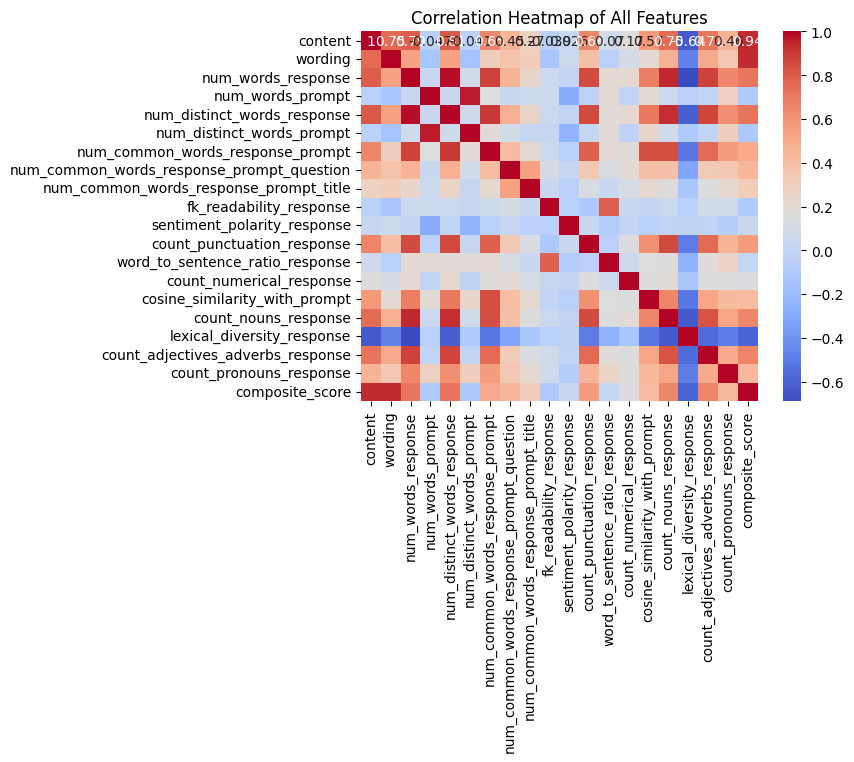

In [13]:
numeric_df = merged_df.select_dtypes(include=['float64','int64'])
corr = numeric_df.corr()

# Generate a heatmap
sns.heatmap(corr,annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of All Features')
plt.show()

d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\dsf\Assignment1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

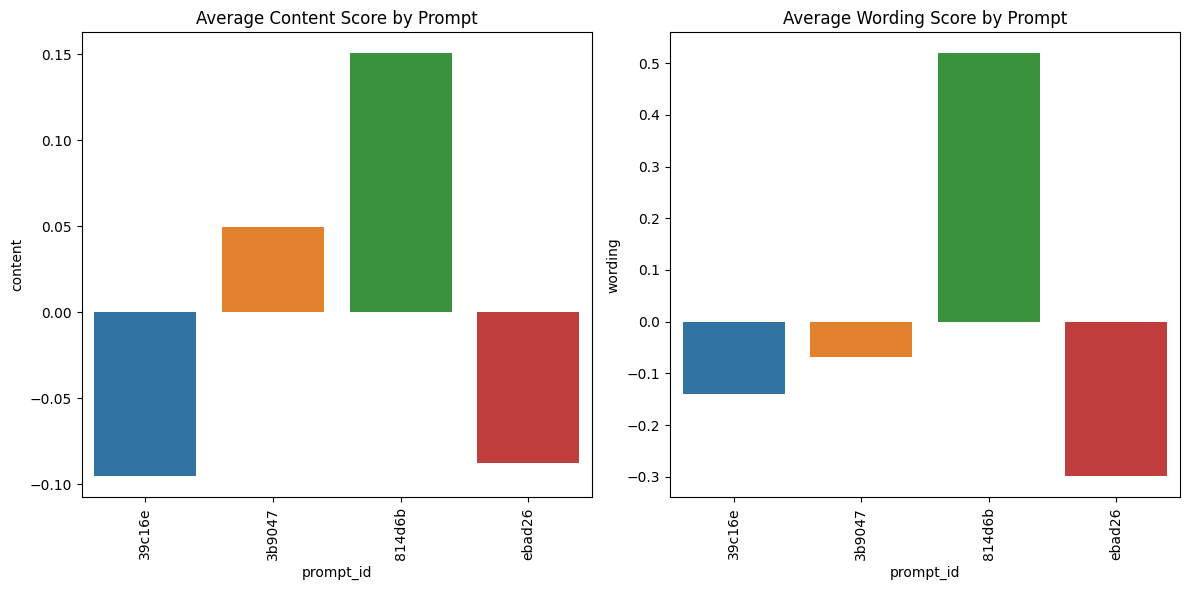

In [14]:

grouped_by_prompt = merged_df.groupby('prompt_id')[['content', 'wording']].mean().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Barplot for 'content'
sns.barplot(x='prompt_id',y='content',data=grouped_by_prompt, ax=axes[0])
axes[0].set_title('Average Content Score by Prompt')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)  

# Barplot for 'wording'
sns.barplot(x='prompt_id', y='wording',data=grouped_by_prompt,ax=axes[1])
axes[1].set_title('Average Wording Score by Prompt')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=90)

plt.tight_layout()
plt.show()


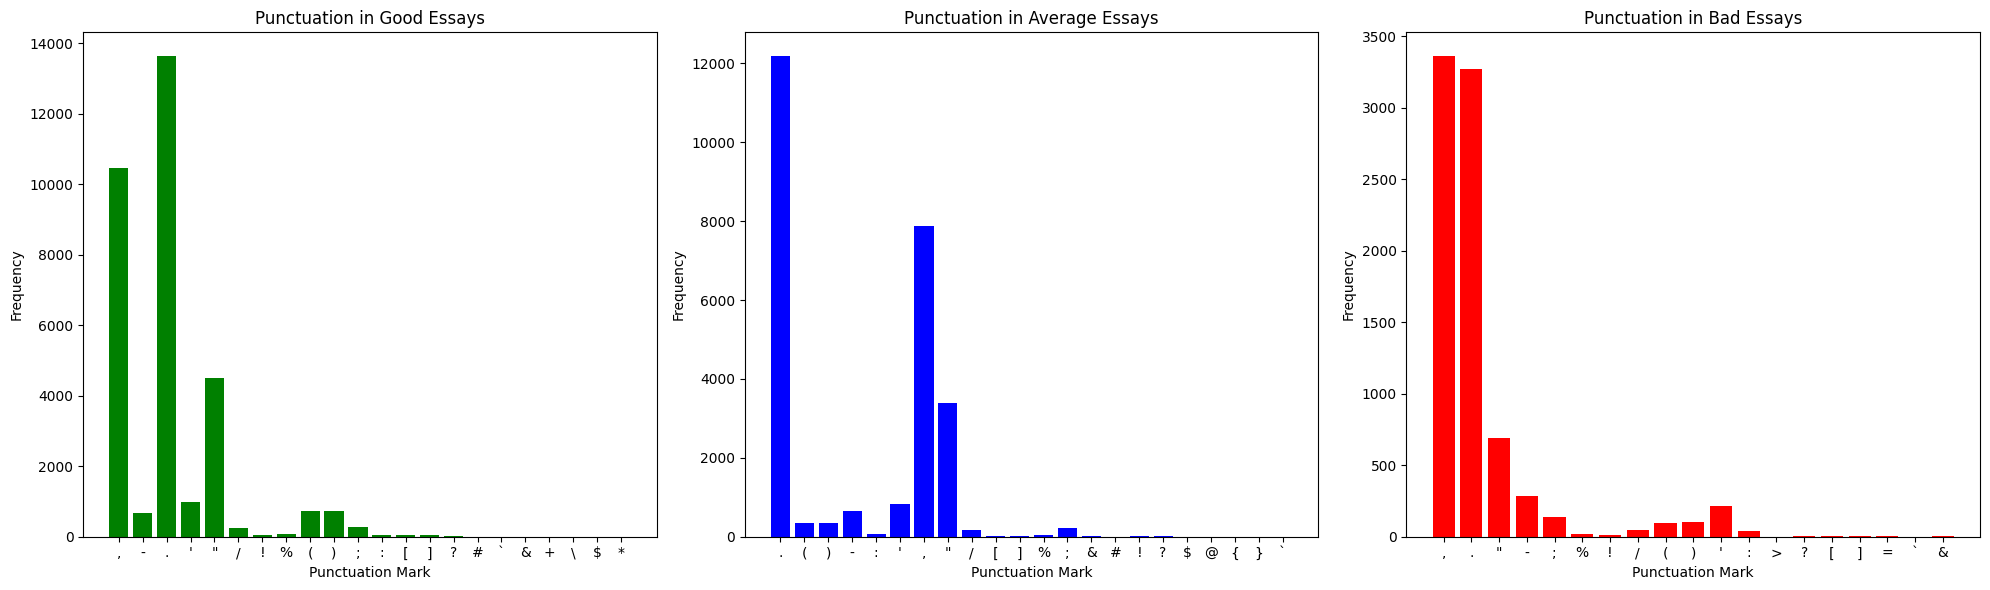

In [15]:
def count_punctuation(texts):
    punctuation_counts =Counter()
    for text in texts:
        punctuation_counts.update(char for char in text if char in string.punctuation)
    return punctuation_counts

good_punct = count_punctuation(good_essays)
bad_punct = count_punctuation(bad_essays)
average_punct = count_punctuation(average_essays)

fig,axes = plt.subplots(1,3, figsize=(20,6))

# Plot for good essays
axes[0].bar(good_punct.keys(),good_punct.values(),color='g')
axes[0].set_title('Punctuation in Good Essays')
axes[0].set_xlabel('Punctuation Mark')
axes[0].set_ylabel('Frequency')

# Plot for average essays
axes[1].bar(average_punct.keys(),average_punct.values(),color='b')
axes[1].set_title('Punctuation in Average Essays')
axes[1].set_xlabel('Punctuation Mark')
axes[1].set_ylabel('Frequency')

# Plot for bad essays
axes[2].bar(bad_punct.keys(), bad_punct.values(),color='r')
axes[2].set_title('Punctuation in Bad Essays')
axes[2].set_xlabel('Punctuation Mark')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Task 7 - Now build a baseline model for this task. We will call this Model 0. You will train linear regression models for both content and wording on 80% of the training data and test it on the remaining 20% chosen at random.  Use only the original five features described above.  Report the mean squared error of each model. What do you make of the error rate?

I tried training Model 0 first using 20-80 training random split and then using 7-fold cross validation. The cross validation method reported slightly better MSE scores (but not that significant, overall the MSE scores for this model are bad, most probably because we are using very rudimentary (the original) features and trying to predict content and wording using them.)
<br><br>
The scores-<br>
Using 80-20 random split training - <br>
- Predicting content:
    - Model 0 MSE: 0.3521
    - Model 0 RMSE: 0.5934
- Predicting wording:
    - Model 0 MSE: 0.5030
    - Model 0 RMSE: 0.7092
<br>
Using 7-fold cross validation training - <br>
- Predicting content:
    - Model 0 Avg MSE with 7-fold CV: 0.3356
    - Model 0 Avg RMSE with 7-fold CV: 0.5793
- Predicting wording:
    - Model 0 Avg MSE with 7-fold CV: 0.4978
    - Model 0 Avg RMSE with 7-fold CV: 0.7055

In [18]:
original_features = ['num_words_response', 'num_words_prompt', 'num_distinct_words_response', 'num_distinct_words_prompt', 'num_common_words_response_prompt', 'num_common_words_response_prompt_question', 'num_common_words_response_prompt_title']
new_features = ['fk_readability_response', 'sentiment_polarity_response', 'count_punctuation_response', 'word_to_sentence_ratio_response', 'count_numerical_response', 'cosine_similarity_with_prompt', 'count_nouns_response', 'lexical_diversity_response', 'count_adjectives_adverbs_response', 'count_pronouns_response']
all_features = original_features + new_features
common_new_features = ['fk_readability_response','sentiment_polarity_response','count_punctuation_response','word_to_sentence_ratio_response','count_numerical_response']
content_features = original_features + common_new_features + ['cosine_similarity_with_prompt','count_nouns_response']
wording_features = original_features + common_new_features + ['lexical_diversity_response','count_adjectives_adverbs_response','count_pronouns_response']

targets = ['content', 'wording']
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

#model0
for target in targets:
    print(f"Predicting {target}:")
    # Model 0: Using only original 7 features
    X_train0 =train_df[original_features]
    y_train0 = train_df[target]
    X_test0 =test_df[original_features]
    y_test0 = test_df[target]

    model0 = LinearRegression()
    model0.fit(X_train0, y_train0)
    y_pred0 =model0.predict(X_test0)
    mse0 = mean_squared_error(y_test0,y_pred0)
    print(f"Model 0 MSE: {mse0:.4f}")
    print (f"Model 0 RMSE: {np.sqrt(mse0):.4f}")


Predicting content:
Model 0 MSE: 0.3521
Model 0 RMSE: 0.5934
Predicting wording:
Model 0 MSE: 0.5030
Model 0 RMSE: 0.7092


Trying training using K fold cross validation for Model 0

In [19]:
k = 7  # Number of folds
for target in targets:
    print(f"Predicting {target}:")

    # Model 0: Using only original 7 features
    X0 =merged_df[original_features]
    y0 = merged_df[target]
    model0 =LinearRegression()
    mse_scores0 = -cross_val_score(model0, X0, y0, cv=k, scoring='neg_mean_squared_error')
    avg_mse0 =np.mean(mse_scores0)
    print(f"Model 0 Avg MSE with {k}-fold CV: {avg_mse0:.4f}")
    print(f"Model 0 Avg RMSE with {k}-fold CV: {np.sqrt(avg_mse0):.4f}")



Predicting content:
Model 0 Avg MSE with 7-fold CV: 0.3356
Model 0 Avg RMSE with 7-fold CV: 0.5793
Predicting wording:
Model 0 Avg MSE with 7-fold CV: 0.4978
Model 0 Avg RMSE with 7-fold CV: 0.7055


Task 8 - The basic features as defined above are not really suited for the task.  Features can be preprocessed (or cleaned) to improve them before feeding into the model (e.g. normalize them, do a special treatment of missing values, etc). This can significantly improve the performance of your model. Do preprocessing for all the features (the original five plus the extra you add). Explain what you did.

Steps undertaken for this task - 
- Filling missing numeric values with mean of that column
- Scale/Normalize all feature values so that they lie between 0 and 1.

In [20]:
numeric_means= merged_df.select_dtypes(include=['float64','int64']).mean()
merged_df.fillna(numeric_means,inplace=True)

In [21]:
scaler = MinMaxScaler()
merged_df[all_features] =scaler.fit_transform(merged_df[all_features])

Task 9 - For each of the two tasks (content and wording) create two models:<br>
Model 1 should use the cleaned features and linear regression for training.  You can do some (potentially non-linear) scaling to keep the scores in range. <br>
Model 2 should use the cleaned features and an algorithm other than logistic regression (e.g. Random Forest, Nearest Neighbor, etc) for training.

Observations from this task - 
- At first I tried buidling 2 models within Model 1, as earlier we decided to keep some features common for wording and content and some features separate for both. So Model1 was trained by combining all features and Model1.1 was trained in such a way that for "content" separate set of features were used and for "wording" separate set of features were used.
- Both 80-20 random split training and 7-fold cross validation method were tested for Models 1 and 1.1 . 
- But the results were very similiar for Model 1 and Model 1.1, with both 80-20 random split training and 7-fold cross validation types of training. So to keep things going forward, I have decided to train the models using all_features as there was no noticable difference separating out features for training and predicting of "content" and "wording".
- Now for Model 2 , I have taken 3 types of model - Random Forest, KNN and Polynomial Regression with degree 2. I tried training these models using 80-20 random split and 7-fold cross validation strategy and found the best performance (lowest MSE/RMSE) was given by both Random Forest and Polynomial regression following the 80-20 random training split technique. kNN Model performed worse than Linear Regression.
- In the end for submission, I would choose either the Random Forest or the Polynomial regression model to calculate the MCRMSE score<br>

The  best model scores are as follows - 
<br>
Model1<br>
- Predicting content:
    - Model 1 MSE: 0.2608
    - Model 1 RMSE: 0.5107
- Predicting wording:
    - Model 1 MSE: 0.3993
    - Model 1 RMSE: 0.6319

<br>
Model2<br>

Random Forest Model - <br>

- Predicting content:
    - Random Forest MSE: 0.2002
    - Random Forest RMSE: 0.4475
- Predicting wording:
    - Random Forest MSE: 0.3494
    - Random Forest RMSE: 0.5911
<br>

2-degree Polynomial Regression Model - <br>

- Predicting content:
    - Polynomial Regression MSE: 0.1930
    - Polynomial Regression RMSE: 0.4394
- Predicting wording:
    - Polynomial Regression MSE: 0.3477
    - Polynomial Regression RMSE: 0.5896

In [22]:
#Model1
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)
for target in targets:
    print(f"Predicting {target}:")
    # # Model 1: Using original 7 features + new features
    X_train1 = train_df[all_features]
    y_train1 = train_df[target]
    X_test1 = test_df[all_features]
    y_test1 = test_df[target]

    model1 = LinearRegression()
    model1.fit(X_train1, y_train1)
    y_pred1 = model1.predict(X_test1)
    mse1 = mean_squared_error(y_test1, y_pred1)
    print(f"  Model 1 MSE: {mse1:.4f}")
    print (f" Model 1 RMSE: {np.sqrt(mse1):.4f}")

Predicting content:
  Model 1 MSE: 0.2608
 Model 1 RMSE: 0.5107
Predicting wording:
  Model 1 MSE: 0.3993
 Model 1 RMSE: 0.6319


In [23]:
k = 7  # Number of folds
for target in targets:
    print(f"Predicting {target}:")
    # Model 1: Using original 7 features + new features
    X1 = merged_df[all_features]
    y1 = merged_df[target]

    model1 = LinearRegression()
    mse_scores1 = -cross_val_score(model1, X1, y1, cv=k, scoring='neg_mean_squared_error')
    avg_mse1 = np.mean(mse_scores1)
    print(f"  Model 1 Avg MSE with {k}-fold CV: {avg_mse1:.4f}")
    print (f" Model 1 Avg RMSE with {k}-fold CV: {np.sqrt(avg_mse1):.4f}")

Predicting content:
  Model 1 Avg MSE with 7-fold CV: 0.2464
 Model 1 Avg RMSE with 7-fold CV: 0.4964
Predicting wording:
  Model 1 Avg MSE with 7-fold CV: 0.4013
 Model 1 Avg RMSE with 7-fold CV: 0.6335


In [24]:
#Model1 with slight modification, using separate features for training of content and wording, let's call it Model1.1
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)
for target in targets:
    print(f"Predicting {target}:")
    if target=="content":
        X_train1 = train_df[content_features]
        X_test1 = test_df[content_features]
    elif target=="wording":
        X_train1 = train_df[wording_features]
        X_test1 = test_df[wording_features]
    y_train1 = train_df[target]
    y_test1 = test_df[target]

    model1 = LinearRegression()
    model1.fit(X_train1,y_train1)
    y_pred1 = model1.predict(X_test1)
    mse1 = mean_squared_error(y_test1, y_pred1)
    print(f"Model 1.1-  MSE: {mse1:.4f}")
    print (f"Model 1.1 RMSE: {np.sqrt(mse1):.4f}")

print ("K-fold cross validation for Model 1.1 results")
k = 7  # Number of folds
for target in targets:
    print(f"Predicting {target}:")
    if target=="content":
        X1 = merged_df[content_features]
    elif target=="wording":
        X1 = merged_df[wording_features]
    y1 = merged_df[target]

    model1 = LinearRegression()
    mse_scores1 = -cross_val_score(model1, X1, y1, cv=k, scoring='neg_mean_squared_error')
    avg_mse1 = np.mean(mse_scores1)
    print(f"Model 1.1 Avg MSE with {k}-fold CV: {avg_mse1:.4f}")
    print (f"Model 1.1 Avg RMSE with {k}-fold CV: {np.sqrt(avg_mse1):.4f}")


Predicting content:
Model 1.1-  MSE: 0.2964
Model 1.1 RMSE: 0.5444
Predicting wording:
Model 1.1-  MSE: 0.4001
Model 1.1 RMSE: 0.6326
K-fold cross validation for Model 1.1 results
Predicting content:
Model 1.1 Avg MSE with 7-fold CV: 0.2829
Model 1.1 Avg RMSE with 7-fold CV: 0.5319
Predicting wording:
Model 1.1 Avg MSE with 7-fold CV: 0.4018
Model 1.1 Avg RMSE with 7-fold CV: 0.6339


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

train_df,test_df = train_test_split(merged_df,test_size=0.2, random_state=42)
models = {
    "Random Forest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())}
targets = ["content", "wording"]

for target in targets:
    print(f"Predicting {target}:")
    X_train =train_df[all_features]
    y_train =train_df[target]
    X_test = test_df[all_features]
    y_test= test_df[target]

    for model_name,model in models.items():
        model.fit(X_train,y_train)
        y_pred= model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse =np.sqrt(mse)
        print(f"{model_name} MSE: {mse:.4f}")
        print(f"{model_name} RMSE: {rmse:.4f}")
    print("\n")



Predicting content:
Random Forest MSE: 0.2021
Random Forest RMSE: 0.4495
KNN MSE: 0.2750
KNN RMSE: 0.5244
Polynomial Regression MSE: 0.1930
Polynomial Regression RMSE: 0.4394


Predicting wording:
Random Forest MSE: 0.3477
Random Forest RMSE: 0.5897
KNN MSE: 0.5011
KNN RMSE: 0.7079
Polynomial Regression MSE: 0.3477
Polynomial Regression RMSE: 0.5896




In [26]:
k=7
for target in targets:
    print(f"Predicting {target}:")
    X= merged_df[all_features]
    y =merged_df[target]
    
    for model_name,model in models.items():
        mse_scores = -cross_val_score(model, X, y, cv=k, scoring='neg_mean_squared_error')
        avg_mse =np.mean(mse_scores)
        print(f"{model_name} Avg MSE with {k}-fold CV: {avg_mse:.4f}")
        print(f"{model_name} Avg RMSE with {k}-fold CV: {np.sqrt(avg_mse):.4f}")
    print("\n")

Predicting content:
Random Forest Avg MSE with 7-fold CV: 0.2059
Random Forest Avg RMSE with 7-fold CV: 0.4537
KNN Avg MSE with 7-fold CV: 0.2751
KNN Avg RMSE with 7-fold CV: 0.5245
Polynomial Regression Avg MSE with 7-fold CV: 0.2004
Polynomial Regression Avg RMSE with 7-fold CV: 0.4477


Predicting wording:
Random Forest Avg MSE with 7-fold CV: 0.3581
Random Forest Avg RMSE with 7-fold CV: 0.5984
KNN Avg MSE with 7-fold CV: 0.4937
KNN Avg RMSE with 7-fold CV: 0.7027
Polynomial Regression Avg MSE with 7-fold CV: 0.3613
Polynomial Regression Avg RMSE with 7-fold CV: 0.6011




Task 10 - Submit your scores on the test set to the Kaggle competition for the best model you develop

As the submission will be judged by MCRMSE scores, we need to calculate the MCRMSE score for our 2 best models, Random Forest and 2-degree Polynomial Regression.

In [27]:
def mcrmse(y_true,y_pred):
    return np.mean(np.sqrt(np.mean(np.square(y_true-y_pred), axis=0)))

train_df,test_df = train_test_split(merged_df, test_size=0.2,random_state=42)
models = {
    "Random Forest": RandomForestRegressor(),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), LinearRegression())
}
targets = ["content", "wording"]
for model_name,model in models.items():
    rmses =[]
    for target in targets:
        X_train =train_df[all_features]
        y_train = train_df[target]
        X_test= test_df[all_features]
        y_test= test_df[target]
        
        model.fit(X_train,y_train)
        y_pred =model.predict(X_test)
        rmse= np.sqrt(mean_squared_error(y_test, y_pred))
        rmses.append(rmse)
        
    mcrmse_score = np.mean(rmses)
    print(f"{model_name} MCRMSE: {mcrmse_score:.4f}")
    print("\n")


Random Forest MCRMSE: 0.5181


Polynomial Regression MCRMSE: 0.5145


